In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
hf = h5py.File('data/channel_x1_256_y1_512_z1_256_step2.h5', 'r')
hf_pressure = h5py.File('data/channel_x1_256_y1_512_z1_256_step2_pressure.h5', 'r')

In [3]:
vels = hf.get('Velocity_0001')
xs = hf.get('xcoor')
ys = hf.get('ycoor')
zs = hf.get('zcoor')
ps = hf_pressure.get('Pressure_0001')

In [4]:
ys = ys[1:]
vels = vels[:, 1:, :, :]
ps = ps[:, 1:, ...]

In [5]:
ys.shape, ps.shape

((255,), (128, 255, 128, 1))

In [6]:
us = vels[..., 0]
vs = vels[..., 1]
ws = vels[..., 2]

In [7]:
# flatten the velocity as we
us_flattened = us.flatten()

In [8]:
# gather all the positions
yv, xv, zv = np.meshgrid(ys, xs, zs) 

In [9]:
# flatten a give slice of data
slice_num = 0
xv_flattened_2d = np.expand_dims(xv[:,:,slice_num].flatten(), axis=1)
yv_flattened_2d = np.expand_dims(yv[:,:,slice_num].flatten(), axis=1)
coords_flattened_2d = np.concatenate((yv_flattened_2d, xv_flattened_2d), axis=1)
print(coords_flattened_2d.shape)

(32640, 2)


In [10]:
us2d = us[:, :, slice_num]
us2d_flattened = np.expand_dims(us2d.flatten(), axis=1)
vs2d = vs[:, :, slice_num]
vs2d_flattened = np.expand_dims(vs2d.flatten(), axis=1)
ps2d = ps[:, :, slice_num]
ps2d_flattened = np.expand_dims(ps2d.flatten(), axis=1)
ws2d = ws[:, :, slice_num]
ws2d_flattened = np.expand_dims(ws2d.flatten(), axis=1)

In [11]:
# create a regular grid to map the dataset values to a 2D grid
grid_x = np.linspace(xv.min(), xv.max(), 256)
grid_y = np.linspace(yv.min(), yv.max(), 256)

In [50]:
# get the positions at which we want to evaluate the flow value - flatten for griddata function
yeval, xeval = np.meshgrid(grid_y, grid_x)
xeval_flattened = np.expand_dims(xeval.flatten(), axis=1)
yeval_flattened = np.expand_dims(yeval.flatten(), axis=1)

In [51]:
# interpolate the values at the regular grid points
us_interp = griddata(coords_flattened_2d, us2d_flattened, (yeval, xeval), method='linear', fill_value=0)
vs_interp = griddata(coords_flattened_2d, vs2d_flattened, (yeval, xeval), method='linear', fill_value=0)
ps_interp = griddata(coords_flattened_2d, ps2d_flattened, (yeval, xeval), method='linear', fill_value=0)
ws_interp = griddata(coords_flattened_2d, ws2d_flattened, (yeval, xeval), method='linear', fill_value=0)

In [52]:
xeval =  np.expand_dims(np.transpose(xeval, axes=(1, 0)), axis=-1)
yeval =  np.expand_dims(np.transpose(yeval, axes=(1, 0)), axis=-1)
us_interp =  np.transpose(us_interp, axes=(1, 0, 2))
vs_interp =  np.transpose(vs_interp, axes=(1, 0, 2))
ps_interp =  np.transpose(ps_interp, axes=(1, 0, 2))

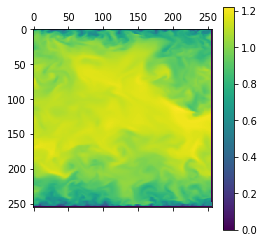

In [53]:
plt.matshow(us_interp[...,0])
plt.colorbar()

In [54]:
flow = np.concatenate((xeval, yeval, us_interp, vs_interp, ps_interp), axis=-1)

In [55]:
flow_padded = np.zeros((300, 300, 5))
flow_padded[22:-22, 22:-22, :] = flow

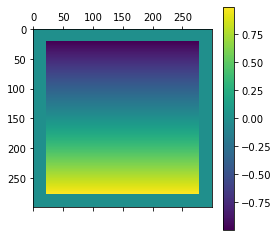

In [59]:
plt.matshow(flow_padded[...,1])
plt.colorbar()

In [18]:
# xv, yv, zv = np.meshgrid(xs, ys, zs) #, indexing="xy")
# gather all the positions
# yv, xv, zv = np.meshgrid(ys, xs, zs) 
# flatten and concatenate the coordinates for future use
# xv_flattened = np.expand_dims(xv.flatten(), axis=1)
# yv_flattened = np.expand_dims(yv.flatten(), axis=1)
# zv_flattened = np.expand_dims(zv.flatten(), axis=1)
# coords_flattened = np.concatenate((yv_flattened, xv_flattened, zv_flattened), axis=1)
# print(coords_flattened.shape)